# NSMC on a simple lattice model

In [47]:
library(RSQMC) # homemade Rcpp package for internal filter functions
#library(mvtnorm)
library(MASS) # for multivariate Gaussian simulation : function mvrnorm
library(parallel)

library(ggplot2) # plotting library

source(file.path(getwd(), "Lattice_Model_Functions.R"))

set.seed(42)

In [48]:
# SMC parameters
T_ <- 15 # time
D <- 2 # dimension -> DxD square
N <- 100 # number of external particles
M <- 32 # number of internal particles
tau <- 1. # coordinates variance
lambda <- 1. # coordinates correlation

# AR(1) parameter
mu = 2
rho = 0.9

In [49]:
# Covariance matrix design
S_inv <- matrix(0, D**2, D**2)

for(n in 1:D){
  for(k in 1:D){
    nb_neighbours = 0
    # (n,k) gives n*D + k position in vector
    vector_index <- (n-1)*D + k
    if (n > 1){ # upper neighbour
      S_inv[vector_index, vector_index - D] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    if (n < D){ # lower neighbour
      S_inv[vector_index, vector_index + D] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    if(k > 1){ # left neighbour
      S_inv[vector_index, vector_index - 1 ] <- -lambda 
      nb_neighbours = nb_neighbours + 1
    }
    if (k < D){ # right neighbour
      S_inv[vector_index, vector_index + 1] <- -lambda
      nb_neighbours = nb_neighbours + 1
    }
    S_inv[vector_index, vector_index] = tau + 2*nb_neighbours*lambda
  }
}

S <- solve(S_inv) # covariance matrix
S <- 10*S # arbitrary calibration

In [50]:
# Trajectory simulation
x <- matrix(0, D**2, T_)
y <- matrix(0, D**2, T_)

x[, 1] <- mvrnorm(n = 1, matrix(mu, D**2), S)
for(d in 1:(D**2)){
  y[d, 1] <- rpois(1, exp(x[d, 1]))
}

for(t in 2:T_){
  x[, t] <- mu + rho*(x[, t-1]-mu) + mvrnorm(n = 1, matrix(0, D**2), S)
  for(d in 1:(D**2)){
    y[d, t] <- rpois(1, exp(x[d, t]))
  }
}

### Prediction comparison

In [51]:
#### NSMC without QMC
particles <- lattice_filter(y, N, M, D, T_, mu, rho, S, QMC=FALSE)

#### NSMC with QMC
particles_QMC <- lattice_filter(y, N, M, D, T_, mu, rho, S, QMC=TRUE)

ERROR: Error in lattice_internal_filter(N, M, D, mu + rho * (particles[, , t - : Not enough positive probabilities


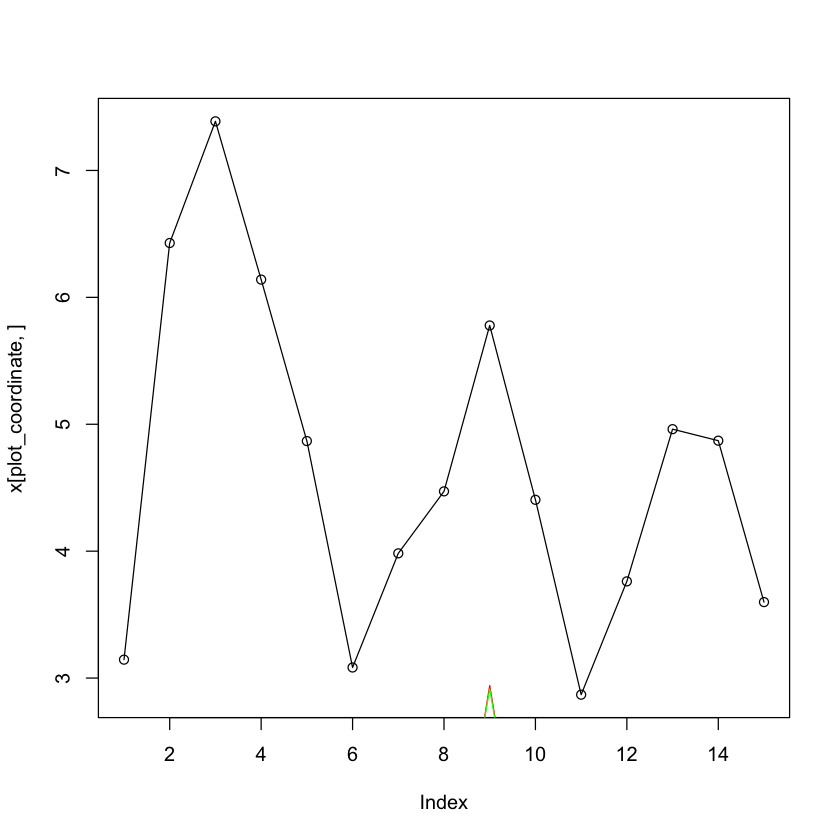

In [52]:
plot_coordinate  = 1

plot(x[plot_coordinate, ])
lines(x[plot_coordinate, ])
lines(apply(particles[, plot_coordinate, 1:T_], 2, mean), col='red')
lines(apply(particles_QMC[, plot_coordinate, 1:T_], 2, mean), col='green')

### Variance comparison

In [54]:
var = array(0, T_)
var_QMC = array(0, T_)

nb_filters <- 2

cl <- makeCluster(2)
clusterExport(cl=cl, varlist=c("x", "y", "N", "M", "D", "T_", "mu", "rho", "S", 
                               "lattice_filter", "mvrnorm", 
                               "observation_lh", "lattice_internal_filter", 
                               "lattice_internal_filter_QMC"))
var <- apply(parSapply(cl, 1:nb_filters, lattice_filter_replicate), 1, var)
var_QMC <- apply(parSapply(cl, 1:nb_filters, lattice_filter_QMC_replicate), 1, var)
stopCluster(cl)

ERROR: Error in checkForRemoteErrors(val): 2 nodes produced errors; first error: NA in probability vector


In [ ]:
df <- data.frame(no_QMC = var, QMC = var_QMC)
df$idu <- as.numeric(row.names(df))

var_plot <- (ggplot(df) + geom_line(aes(x=idu, y=no_QMC, color='No QMC'), size=1) + 
geom_line(aes(x=idu, y=QMC, color='QMC'), size=1) + xlab("Time") + ylab("Variance")) 

savename <- paste('plots/variance/variance_lattice', D**2,'_', N, '_', M, '.pdf', sep="")
ggsave(filename=savename, plot=var_plot, height=5,width=12,dpi=72)

var_plot